## Train MM / explore

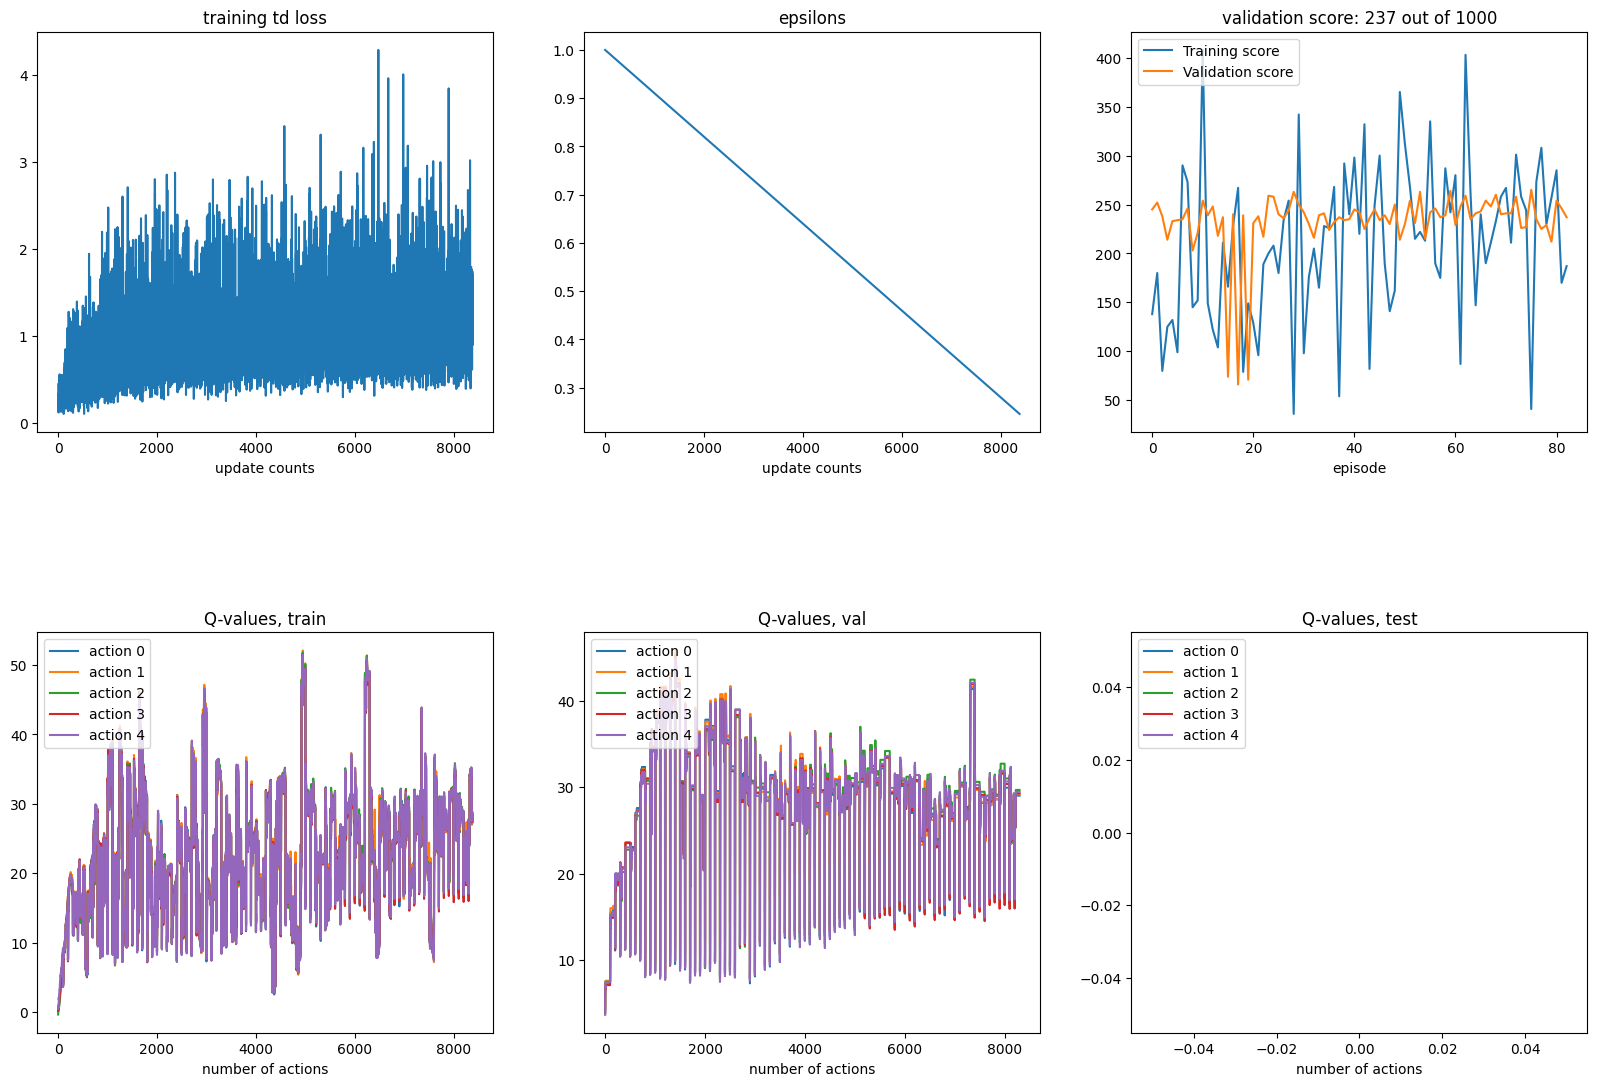

In [1]:
from agent import DQNAgent
import logging
from tqdm.auto import tqdm
import random

logger = logging.getLogger()
logger.disabled = True

room_size = "l"

params_all = []
for capacity_max in [6, 12, 24, 48, 96]:
    for test_seed in range(5):
        pretrain_semantic = False
        num_iterations = 100 * 100
        batch_size = 32
        question_interval = 1
        terminates_at = 99

        capacity_h = {
            "episodic": capacity_max // 2,
            "semantic": capacity_max // 2,
            "short": 1,
        }
        capacity_e = {
            "episodic": capacity_max,
            "semantic": 0,
            "short": 1,
        }
        capacity_s = {
            "episodic": 0,
            "semantic": capacity_max,
            "short": 1,
        }

        for capacity in [capacity_h, capacity_e, capacity_s]:
            params = {
                "env_str": "room_env:RoomEnv-v2",
                "num_iterations": num_iterations,
                "replay_buffer_size": num_iterations,
                "warm_start": num_iterations // 10,
                "batch_size": batch_size,
                "target_update_interval": 10,
                "epsilon_decay_until": num_iterations,
                "max_epsilon": 1.0,
                "min_epsilon": 0.1,
                "gamma": {"mm": 0.99, "explore": 0.9},
                "capacity": capacity,
                "pretrain_semantic": pretrain_semantic,
                "lstm_params": {
                    "hidden_size": 64,
                    "num_layers": 2,
                    "embedding_dim": 64,
                    "bidirectional": False,
                    "max_timesteps": 100,
                    "max_strength": 100,
                },
                "mlp_params": {
                    "hidden_size": 64,
                    "num_hidden_layers": 1,
                    "dueling_dqn": True,
                },
                "num_samples_for_results": 10,
                "plotting_interval": 10,
                "train_seed": test_seed + 5,
                "test_seed": test_seed,
                "device": "cpu",
                "qa_function": "episodic_semantic",
                "explore_policy_heuristic": "avoid_walls",
                "env_config": {
                    "question_prob": 1.0,
                    "terminates_at": terminates_at,
                    "randomize_observations": "objects",
                    "room_size": room_size,
                    "rewards": {"correct": 1, "wrong": 0, "partial": 0},
                    "make_everything_static": False,
                    "num_total_questions": 1000,
                    "question_interval": question_interval,
                    "include_walls_in_observations": True,
                },
                "ddqn": True,
                "default_root_dir": f"./training-results/dqn/room_size={room_size}/capacity={capacity_max}/episodic={capacity['episodic']}_semantic={capacity['semantic']}/pretrain_semantic={pretrain_semantic}",
            }
            params_all.append(params)

for params in tqdm(params_all):
    agent = DQNAgent(**params)
    agent.train()